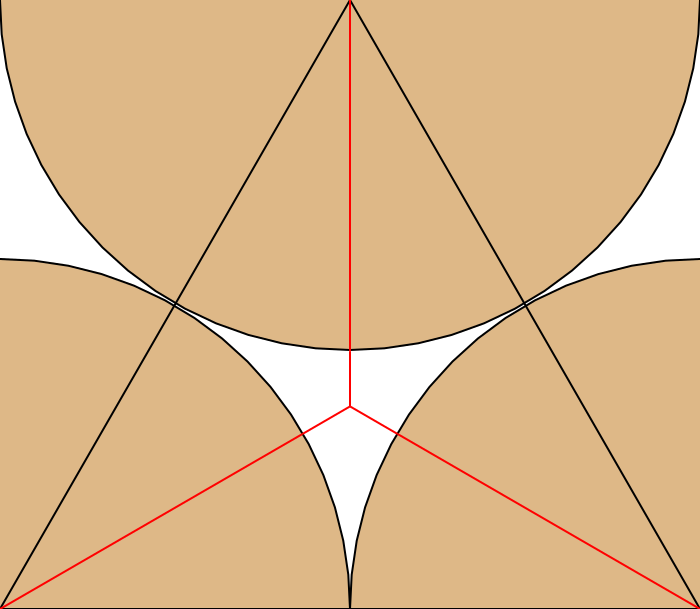

In [7]:
import networkx as nx
from itertools import count, combinations
from shapely.geometry import Polygon, Point, MultiPoint, LineString, MultiLineString
from shapely.ops import split, polygonize

from sample_trees import *
from render_pattern import *
from helper_functions import *

STEP = 10
EPSILON = 3
ROUND_PRECISION = 6

def contract_triangle(triangle):
    
    # find the angular bisectors of the triangle
    bisectors = angular_bisectors(triangle)
    
    # find intersection point between any of the bisectors
    intersection = bisectors[0].intersection(bisectors[1])
    
    #return the angular bisectors until they intersect
    return [line_from_points(v,intersection) for v in get_vertices(triangle)]   

# helper functions:
# geom.is_empty
# connect_points(points)
# coords(geom)
# enumerate(list)
# extend_lines(lines,extension)
# dict.pop(entry)
def sweep(polygon,sweep_length,node_map,distances,active,node_map_origin,h_last=0,creases=[],guides=[],h=0):      
    # shrink the polygon
    polygon_prime = polygon.buffer(-sweep_length)    
    
    # TODO: look for contraction events, == the polygon ceases to exist
        # TODO: connect the endpoints to eachother
        return creases, guides   
    # TODO: generate creases, iterate over vertices of polygon skipping the first vertex    
        # TODO: find corresponding vertices on the prime polygon   
        # TODO: extend the crease lines with a line between each vertex and their prime counterpart
        # TODO: update the node map

    # recursively call the shrinking with the new polygon
    return sweep(polygon_prime,sweep_length, node_map,distances, active, 
                 node_map_origin, h_last, creases, guides,h)


def get_active_paths(polygon,node_map,dist):
    # initiate a matrix of for all combinations of nodes
    M = np.zeros((len(node_map),len(node_map)))
    
    # traverse all combinations of vertices in polygon
    for p1,p2 in combinations(get_vertices(polygon),2):
        
        # get the corresponding nodes
        node1, node2 = get_nodes(p1,node_map),get_nodes(p2,node_map)
        
        # set the path between the ndoes to 1 if the distance is bigger than epsilon, otherwise -1
        M[node1][node2] = 1 if p1.distance(p2)-tree_distance(node1,node2,dist) > EPSILON else -1
    
    return M


def get_lang_polys(points,node_map,active):
    
    # add all active edges to the polys
    edges = [line_from_nodes(nodes[0],nodes[1],node_map) for nodes in query_matrix(active,-1)] 
    
    # find inactive edges
    active_edges = [line_from_nodes(nodes[0],nodes[1],node_map) for nodes in query_matrix(active,1)] 
    
    # add inactive edges to polygon if they are on the outside
    edges += [line for line in active_edges if is_on_polygon(line,convex_polygon(points)) and not_in_collection(line,to_collection(edges))] 
    
    # create a list of polygons from the edges
    return list(polygonize(edges))


# load a tree, corresponding points and a map between points and nodes
points,node_map,tree,tree_distances = threeNodesTree()

# find active paths from the points
active_paths = get_active_paths(Polygon(points),node_map,tree_distances)

# create polygons from active paths or paths on the edge of the paper
polys = get_lang_polys(points,node_map,active_paths)

# shrink the polygons to find their creases
for polygon in polys:
    active_paths = get_active_paths(polygon,node_map,tree_distances)
    crease_lines,guide_lines = sweep(polygon,STEP,node_map.copy(),tree_distances,active_paths,node_map)


# place circles for visual guidance
circles = [point.buffer(get_edge_weight(tree,get_nodes(point,node_map))) for point in points]

# render the result to export.svg
render(points,circles,polys,crease_lines,guide_lines)
